<a href="https://colab.research.google.com/github/dxvsh/LearningPytorch/blob/main/Week2/Tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from ipywidgets import Layout, interact, interactive, fixed, interact_manual, widgets
from IPython.display import display

In [2]:
import pandas as pd
from pprint import pprint

In [3]:
# to display a pair of subtokens to be merged in a slider
def get_pairs(pair:int):
    """
    pair: index of the pair.
    """
    if pair>0:
        left, right = lines[pair].strip('\n').split(' ')
        print(f'{left} , {right}')

# to display token ids  in a slider
def display_token_id(id):
    token,id = vocab_sorted[id]
    print(f'id:{id} \t token:{token}')



---

Note book starts here


<h1 style="color:Tomato;"> Dataset </h1>

In [4]:
# install the datasets package
!pip install datasets > /dev/null

In [8]:
from datasets import load_dataset, get_dataset_config_info, get_dataset_infos

We will use the `bookcorpus` dataset to train a tokenizer. It may take about 15 minutes or more to download and generate the split for the first time. In my case, it took me 28 minutes to get this dataset loaded in colab.

It requires approximately 5 GB of memory to load the dataset. Please ensure you have sufficient memory available. If not, consider loading only a fraction of the dataset.

In [13]:
ds = load_dataset('bookcorpus',split='all')
pprint(ds)

Dataset({
    features: ['text'],
    num_rows: 74004228
})


In [21]:
ds[100_000] # checking a random sample from the dataset

{'text': "he honestly cared for mia-anyone could see that-but what would he do if he knew she carried another man 's child ?"}

The dataset contains 74 million sentences of varying lengths.

The length of sentences does not affect the training of a tokenizer.

Let's take a look at a few examples from the dataset.

In [27]:
for idx in range(5):
    print(f"{idx} : {ds[idx]['text']}")

0 : usually , he would be tearing around the living room , playing with his toys .
1 : but just one look at a minion sent him practically catatonic .
2 : that had been megan 's plan when she got him dressed earlier .
3 : he 'd seen the movie almost by mistake , considering he was a little young for the pg cartoon , but with older cousins , along with her brothers , mason was often exposed to things that were older .
4 : she liked to think being surrounded by adults and older kids was one reason why he was a such a good talker for his age .


<h1 style="color:Tomato;"> Tokenization </h1>

Recall that a `tokenization` pipeline consists of **Normalizer**, **Pre-Tokenizer**, **Model** and **Post-Processor** as shown below.

- Normalizer : can use lower case based normalization or stripping all accents
- Pre-tokenization : word based or RegEx based
- Algorithm/Model : BPE, WordPiece, SentencePiece
- Post Processing : Insert model specific tokens like [CLS], [SEP]

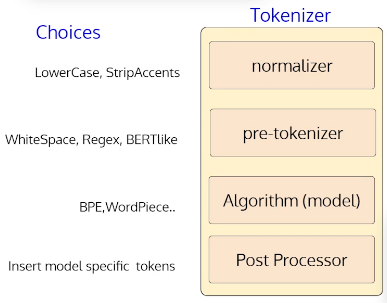





Let us build a simple tokenizer pipeline by importing the `Tokenizer` class.

In [28]:
from tokenizers import Tokenizer

Let's use a simple tokenizer with the following choices for each component:

|**Component** |**Choice**  |
|:------------:|:----------:|
|normalizer    |Lowercase   |
|pre-tokenizer |Whitespace  |
|model         | BPE        |
|postprocessor | None       |

In [30]:
from tokenizers.normalizers import Lowercase
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE

Initiate the tokenizer with the **BPE** model and the special tokens ("[UNK]" in this case) that the model will use during **prediction**

We've specified `[UNK]` to be used as the unknown token. So whenever the tokenizer sees an unknown word it has never encountered before during inference/prediction time, it will replace it with the unknown token `[UNK]`, indicating it has not learned how to tokenize that word.

In [31]:
model = BPE(unk_token="[UNK]")
tokenizer = Tokenizer(model)

Add the **normalizer** (lowercase in this case) and **pre-tokenizer** (whitespace in this case) to the pipeline

In [32]:
tokenizer.normalizer = Lowercase()
tokenizer.pre_tokenizer = Whitespace()

### Create a trainer for the tokenizer

Now we need to create a **trainer** by setting `vocab_size` and `special_tokens`

- In this case, we've specified the `vocab_size` (which is the size of the final vocabulary learnt) to be 32K

- `special_tokens` are set to `["[PAD]", "[UNK]"]`. These are special tokens to be used for padding and unknown words

- `continuing_sub_word_prefix` is set to `##`. This prefix is added to subwords that continue a word. For eg: `["speak", "##ing"]`

In [35]:
from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(vocab_size=32_000,
                        special_tokens=["[PAD]","[UNK]"],
                        continuing_subword_prefix='##',
                        show_progress=True)

In [34]:
?BpeTrainer

The pipeline is ready. Next,we need to pass **list** of strings as input to the tokenizer

However, creating an additional **list** containing all 74 million samples will require an extra 5 GB of memory.

To reduce the memory usage, let us create a generator that returns a batch of samples as a list

In [36]:
def get_examples(batch_size=1000):
    for i in range(0, len(ds), batch_size):
        yield ds[i : i + batch_size]['text']

Let us train the tokenizer using this generator:

<img src=https://raw.githubusercontent.com/Arunprakash-A/Modern-NLP-with-Hugging-Face/refs/heads/main/Notebooks/images/trainer.png>

In [37]:
from multiprocessing import cpu_count
print(cpu_count())

2


We're now training the tokenizer we setup earlier using the generator, it yields 10,000 sample each time. This is much better than just passing all the 74 million samples at one go. We also need to pass it the BpeTrainer object we created.

In [38]:
tokenizer.train_from_iterator(get_examples(batch_size=10000),trainer=trainer,length=len(ds))

The training took about 22 minutes to complete on the free colab and required an additional 1 GB of memory.

It would be interesting to see the subtokens that were merged to create the final vocabulary.

In [40]:
!mkdir model
tokenizer.model.save('model',prefix='hopper')

['model/hopper-vocab.json', 'model/hopper-merges.txt']

Let's see what were the initial merges done by BPE

In [41]:
with open('model/hopper-merges.txt','r') as file:
    row = 0
    num_lines = 10
    for line in file.readlines():
        print(line)
        row+=1
        if row >= num_lines:
            break


#version: 0.2

##h ##e

t ##he

##i ##n

##e ##r

##e ##d

##o ##u

##n ##d

##in ##g

t ##o



Display last `n` merges

We can see by the end of training, we're getting much better tokens

In [43]:
with open('model/hopper-merges.txt','r') as file:
    row = 0
    num_lines = 10
    for line in reversed(file.readlines()):
        print(line)
        row+=1
        if row >= num_lines:
            break

mel ##anthe

black ##er

ad ##ject

v ##ang

betroth ##al

tiptoe ##ing

restroom ##s

consol ##ing

esp ##ionage

influ ##x



<h1 style="color:Tomato;"> Vocabulary </h1>

Let's view the number of merges that happened

In [44]:
with open('model/hopper-merges.txt','r') as file:
    lines = file.readlines()

In [45]:
print(f'Number of merges:{len(lines)}')

Number of merges:31871


In [46]:
print(f'vocab size:{tokenizer.get_vocab_size()}')

vocab size:32000


The number of merges is slightly less than the size of the vocabulary because the merges do not include single-character tokens, such as letters, numbers, and special symbols.

We can view the final learned vocabulary either from the saved `hopper-vocab.json` file or by using the `get_vocab` method.

In [47]:
vocab = tokenizer.get_vocab()

In [49]:
# vocab

For convenience, let's print the vocabulary sorted by token IDs.

In [50]:
vocab_sorted = sorted(vocab.items(), key=lambda item: item[1])

Let's adjust the sliders below to view the **merged subwords** and their corresponding tokens in the vocabulary.

In [51]:
_ = interact(get_pairs,pair=widgets.IntSlider(min=1, max=len(lines)-1, step=1, value=1,layout=Layout(width='900px')))
_ = interact(display_token_id,id=widgets.IntSlider(min=0, max=31999, step=1, value=130,layout=Layout(width='900px')))

interactive(children=(IntSlider(value=1, description='pair', layout=Layout(width='900px'), max=31870, min=1), …

interactive(children=(IntSlider(value=130, description='id', layout=Layout(width='900px'), max=31999), Output(…

Note that the 130th ID represents the first merge. What will the next two tokens to be merged be? You can explore this by moving the sliders.

The sub-words are `t` and `##he`. After the merge, they will form the token `the`.

Similarly the last two merges are: `mel ##anthe` and `black ##er` (Move the slider to the far right to see them.)
You can also use the arrow keys instead of sliders for more precise control

<h1 style="color:Tomato;"> Encoding </h1>

Now how do we encode samples using the tokenizer we've trained?

Let's try passing a single sample to the `encode` method of the tokenizer class

In [53]:
sample = ds[0]['text']
print(f'sample: {sample}')

# encode the sample using the tokenizer
encoding = tokenizer.encode(sample)
print(encoding)

sample: usually , he would be tearing around the living room , playing with his toys .
Encoding(num_tokens=16, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


It returned the output as `Encoding` object that contains useful attributes such as `token_ids` (ids), `type_ids` and so on

We need to access these attributes to get their respective values

In [54]:
token_ids = encoding.ids
tokens = encoding.tokens
type_ids = encoding.type_ids
attention_mask = encoding.attention_mask

In [57]:
# let's try visualising our encoded example
from tokenizers.tools import EncodingVisualizer
visualizer = EncodingVisualizer(tokenizer=tokenizer)
visualizer(text=sample)

# looks like for this sample, no words were split into sub words

In [58]:
out_dict = {'tokens':tokens,'ids':token_ids,'type_ids':type_ids,'attention_mask':attention_mask}
df = pd.DataFrame.from_dict(out_dict)
df

,tokens,ids,type_ids,attention_mask
0,usually,2462,0,1
1,",",19,0,1
2,he,149,0,1
3,would,277,0,1
4,be,162,0,1
5,tearing,6456,0,1
6,around,422,0,1
7,the,131,0,1
8,living,1559,0,1
9,room,536,0,1


`type_ids` are model-specific. For instance, BERT-like models use type IDs of 0 and 1.

Another important attribute is the **`attention_mask`**, which is used in nearly all transformer-based architectures. In this mask, the value is **1** **for tokens to be attended to** and **0 for masked tokens** (won't be attended to) (which may seem counterintuitive given the term "masking").

<br>

To put it plainly:
- if the attention mask for a token is 1, you pay attention to it.
- if it is 0, its an instruction to your model to not pay attention to it.

<h1 style="color:Tomato;">  Batch Encoding </h1>

When encoding a batch of samples, we need to`[PAD]` shorter sequences in the batch, a process known as **dynamic batching**.

For example, lets say we have 10 samples in a batch, and each of those sentences is of different length. Say one has 20 words and another has 34 and so on...

So we need to find the largest sentence in the sample (say it has 50 words), and then we add the required amount of padding in each of the shorter sentences so that they are also of the same length now (for eg, all of the sentences will be sufficiently padded so they have length 50)

Therefore, we use `encode_batch` method of the tokenizer object.

The `token_id` for the `[PAD]` token is 0

In [84]:
samples = ds[0:4]['text']

# a batch of 4 samples
samples

['usually , he would be tearing around the living room , playing with his toys .',
 'but just one look at a minion sent him practically catatonic .',
 "that had been megan 's plan when she got him dressed earlier .",
 "he 'd seen the movie almost by mistake , considering he was a little young for the pg cartoon , but with older cousins , along with her brothers , mason was often exposed to things that were older ."]

In [94]:
batch_encoding = tokenizer.encode_batch(samples)
pprint(batch_encoding)

[Encoding(num_tokens=16, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=14, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=14, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=42, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]


In [95]:
np.reshape(batch_encoding[0].tokens, (1, -1))

array([['usually', ',', 'he', 'would', 'be', 'tearing', 'around', 'the',
        'living', 'room', ',', 'playing', 'with', 'his', 'toys', '.']],
      dtype='<U7')

The maximum length of the sequence in the batch is 42 and the other samples are much shorter. Clearly, **padding** is **not applied** to the remaining samples currently.

In general, it is also possible for the length of a sequence to exceed the model's context length (or window size). In this case, we can enable **truncation**. If the model's context length is 512, i.e., it can't handle sequences longer than 512 tokens, we can enable truncation so that our tokenizer truncates any sequences/samples that are longer than 512 tokens. The tokenizer will cut off sentences at the 512 token limit and won't tokenize the entire sentence.


Assuming the model's context length is 512, enable padding and truncation while batching the samples.

In [99]:
# all default args
tokenizer.enable_padding(direction = 'right',
                         pad_id = 0,
                         pad_type_id = 0,
                         pad_token = '[PAD]',
                         length = None, # None default to max_len in the batch
                         pad_to_multiple_of = None)

# enable truncation
tokenizer.enable_truncation(max_length=512)


In [100]:
batch_encoding = tokenizer.encode_batch(samples)
pprint(batch_encoding)

[Encoding(num_tokens=42, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=42, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=42, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=42, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]


After enabling padding, we can see that all samples in the batch are of the same length i.e. 42.

In [101]:
# the first sample which only had 16 tokens is padded so that it too has 42 tokens now
np.reshape(batch_encoding[0].tokens, (1, -1))

array([['usually', ',', 'he', 'would', 'be', 'tearing', 'around', 'the',
        'living', 'room', ',', 'playing', 'with', 'his', 'toys', '.',
        '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
        '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
        '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
        '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']], dtype='<U7')

<h1 style="color:Tomato;">  Quick test </h1>

Let's **pass a test sequence** that contains two **tokens not present in the vocabulary**.

In [102]:
text = "All this is so simple to do in HF இ😊."
encoded = tokenizer.encode(text).tokens
print(encoded)

['all', 'this', 'is', 'so', 'simple', 'to', 'do', 'in', 'h', '##f', '[UNK]', '[UNK]', '##.']


Normalization worked as expected (This $\rightarrow$ this, HF $\rightarrow$ hf)

Pre-tokenization followed by model tokenization has been applied correctly.

The continuing prefix has been used appropriately. ('##f', '##.`)

And the emojis that were passed in the input sentence were clearly not in the training data, so the tokenizer has tokenized them with the unknown `[UNK]` token as expected.

<h1 style="color:Tomato;">  Saving and Loading Tokenizer </h1>

Let us **save the tokenizer** and load it in a single line of code in the model training script

In [103]:
tokenizer.save('hopper.json')

It **saves all the required information** such as `added_tokens`, details of the `model` (vocab,merges,..) , `normalizer`, `pre-tokenizer` .. all of the details of our tokenizer pipeline is saved correctly

In [104]:
import json
with open('hopper.json','r') as file:
    json_data = json.load(file)

In [107]:
pprint(json_data, depth=1)

{'added_tokens': [...],
 'decoder': None,
 'model': {...},
 'normalizer': {...},
 'padding': {...},
 'post_processor': None,
 'pre_tokenizer': {...},
 'truncation': {...},
 'version': '1.0'}


It is now easy to **load the tokenizer back**

In [108]:
trained_tokenizer = Tokenizer(BPE())

In [110]:
# load the tokenizer back from the file
trained_tokenizer = trained_tokenizer.from_file('hopper.json')

In [111]:
# check that it still works the same as before
tokens = trained_tokenizer.encode(text).tokens
print(tokens)

['all', 'this', 'is', 'so', 'simple', 'to', 'do', 'in', 'h', '##f', '[UNK]', '[UNK]', '##.']


<h1 style="color:Tomato;"> BERT Tokenizer </h1>

Let’s quickly build a BERT-like tokenizer (don’t worry about what BERT-like models are for now)

The input to BERT models generally follows the template below, with slight variations across different BERT implementations.

[ `[CLS]`, token-A_1, $\cdots$, token-A_n, `[SEP]`, token-B_1, $\cdots$, token-B_m ]

> Here `A` denotes sentence `A` with `n` tokens and `B` denotes  sentence `B` with `m` tokens.

> So essentially: `[[CLS], first sentence tokens, [SEP], second sentence tokens]`

BERT like models expect their input to be in the format specified above, and so therefore our bert tokenizer should also take input samples and transform it to the above specified format

The special tokens are : `[CLS]`,`[SEP]`,`[PAD]`,`[MASK]` and `[UNK]`

In [113]:
# set up the tokenizer and trainer objects

bert_tokenizer = Tokenizer(BPE(unk_token='[UNK]'))
bert_tokenizer.normalizer = Lowercase()
bert_tokenizer.pre_tokenizer = Whitespace()
bert_trainer = BpeTrainer(vocab_size=32000,
                          special_tokens=["[PAD]","[UNK]","[CLS]","[SEP]","[MASK]"],
                          continuing_subword_prefix='##')

We just need to add `post_processing_step` where the special tokens are inserted according to  the template

In [114]:
from tokenizers.processors import TemplateProcessing

Since BERT like models expect their inputs to be in a specific format, our tokenizer should take any given input and transform it to the BERT compatible format before passing it on to the BERT model.


* If we pass a single sentence, the tokenizer should output `"[CLS] $0 [SEP]"` where 0 denotes the `type_id` (which defaults to zero if there is a single sentence) <br>

* If we pass a pair of sentence, the tokenizer should output `"[CLS] $A:0 [SEP] $B:1"`

This post processing ensures that the encoded output is returned in the BERT compatible format.

In [115]:
# defining the post processing step

bert_tokenizer.post_processor = TemplateProcessing(single="[CLS] $0 [SEP]", # if a single sentence is passed, format it like this
                                                   pair="[CLS] $A [SEP] $B:1", # <-- if a pair of sentence is passed, format it like this
                                                   special_tokens=[("[CLS]", 2), ("[SEP]", 3)],
                                                   # this means 'CLS' token has a token ID of 2, and 'SEP' token has a token ID of 3
                                                  )

Train the BERT tokenizer using our generator which yields a batch of samples at a time. This again took around 22 minutes on colab.

In [116]:
bert_tokenizer.train_from_iterator(get_examples(batch_size=10000),trainer=bert_trainer,length=len(ds))

In [131]:
bert_tokenizer.save('bert.json')

### Testing the BERT tokenizer

Pass a single sentence to the tokenizer and see if it outputs tokens in the desired format, i.e.

`[CLS] sentence A tokens [SEP]`

In [120]:
text = "All these are so simple to do in HF. Let's do more"
encoded = bert_tokenizer.encode(text)
tokens = encoded.tokens
ids = encoded.ids
out_dict = {'tokens':tokens,'token_ids':ids}
pprint(out_dict,depth=2,compact=True)

{'token_ids': [2, 270, 956, 336, 231, 2534, 141, 206, 157, 56, 93, 24, 462, 17,
               67, 206, 387, 3],
 'tokens': ['[CLS]', 'all', 'these', 'are', 'so', 'simple', 'to', 'do', 'in',
            'h', '##f', '.', 'let', "'", 's', 'do', 'more', '[SEP]']}


Observe that it has returned the output in the desired format.

Let's pass a pair of sentences and see if it outputs tokens in the desired format, i.e.,

`[CLS] sentence A tokens [SEP] sentence B tokens`

In [122]:
text = "All these are so simple to do in HF. Let's do more"
pair = "We have a long way to go!"

encoded = bert_tokenizer.encode(text,pair)
tokens = encoded.tokens
ids = encoded.ids
out_dict = {'tokens':tokens,'token_ids':ids}
pprint(out_dict,depth=2,compact=True)

{'token_ids': [2, 270, 956, 336, 231, 2534, 141, 206, 157, 56, 93, 24, 462, 17,
               67, 206, 387, 3, 214, 250, 49, 490, 415, 141, 260, 12],
 'tokens': ['[CLS]', 'all', 'these', 'are', 'so', 'simple', 'to', 'do', 'in',
            'h', '##f', '.', 'let', "'", 's', 'do', 'more', '[SEP]', 'we',
            'have', 'a', 'long', 'way', 'to', 'go', '!']}


Again, the output is in the BERT format for this case as well

<h1 style="color:Tomato;"> Decoding </h1>

Now at the decoding time, the **special tokens** (for ex, `[PAD]`) **need to be removed** and **sub-words have to be merged** before outputting the final result to the end user.

Let us decode the enoced `token_ids` from the previous step.

In [123]:
plain_tokens = bert_tokenizer.decode(ids)
print(plain_tokens)

all these are so simple to do in h ##f . let ' s do more we have a long way to go !


The special tokens were removed, but note that the **subword** `(h, ##f)` **wasn't merged into a complete word.**

We need to use appropriate decoders based on the type of tokenizer. See the list of decoders [here](https://huggingface.co/docs/tokenizers/v0.13.4.rc2/en/api/decoders)

In [124]:
from tokenizers.decoders import WordPiece

In [126]:
bert_tokenizer.decoder = WordPiece(prefix='##') # specify the prefix used by continuing sub words

In [127]:
plain_tokens = bert_tokenizer.decode(ids)
print(plain_tokens)

all these are so simple to do in hf. let ' s do more we have a long way to go!


The tokens are now properly decoded and the sub words are appropriately merged as well!

<h1 style="color:Tomato;">  Pretrained Tokenizer </h1>

Finally, we need to wrap everything in a `PreTrainedTokenizer` class.

Recall that using `tokenizer.encode` returns `Encoding` with a list of attributes that includes `ids`, `type_ids`, `tokens`, `attention_mask` and many more

In [128]:
encoding = tokenizer.encode(text)
print(encoding)

Encoding(num_tokens=16, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In general, the model requires the `input_ids`, `attention_mask` and other model specific attributes. The `PreTrainedTokenizer` class helps us get all this information for a sample in one shot!

In [130]:
from transformers import PreTrainedTokenizerFast

In [132]:
pt_tokenizer = PreTrainedTokenizerFast(tokenizer_file='hopper.json', # specify the tokenizer file
                                      unk_token='[UNK]',
                                      pad_token='[PAD]',
                                      model_input_names=["input_ids","token_type_ids","attention_mask"],
                                      )

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Now we can simply call the `pt_tokenizer` with an input. See the call signature [here](https://huggingface.co/docs/transformers/v4.44.2/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__)

In [134]:
model_inputs = pt_tokenizer(text)
pprint(model_inputs, compact=True)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [267, 953, 333, 228, 2531, 138, 203, 154, 53, 97, 21, 459, 14, 64,
               203, 384],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


Observe, how the `PreTrainedTokenizer` object has given us everything neatly, including the `attention_mask` for tokens, `token_ids`, etc...

We can now pass easily this to a model.

This also works when you have pairs of sentences:

In [136]:
model_inputs = pt_tokenizer(text, text_pair=pair)
pprint(model_inputs,compact=True)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1],
 'input_ids': [267, 953, 333, 228, 2531, 138, 203, 154, 53, 97, 21, 459, 14, 64,
               203, 384, 211, 247, 46, 487, 412, 138, 257, 9],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
                    1, 1, 1, 1]}


Note that there is an additional `type id`. There are no special tokens `[CLS]:2`,`[SEP]:3` as we haven't used `bert_tokenizer`.

Had we passed the `bert_tokenizer` `json` file, the CLS and SEP tokens would've showed up as well.

We can also pass a **batch** of samples and it works!

In [137]:
batch_text = ['I like the book The Psychology of Money','I enjoyed watching the Transformers movie','oh! thanks for this']

In [138]:
model_inputs = pt_tokenizer(batch_text)
pprint(model_inputs,compact=True)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1]],
 'input_ids': [[54, 281, 131, 1701, 131, 19478, 153, 1564],
               [54, 4096, 1443, 131, 7744, 307, 3760],
               [772, 9, 1767, 200, 254]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0]]}


You can observe that the 3 samples have different number of tokens. Padding is not done by default so let's enable padding:




In [140]:
model_inputs = pt_tokenizer(batch_text, padding=True)
pprint(model_inputs,compact=True)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0],
                    [1, 1, 1, 1, 1, 0, 0, 0]],
 'input_ids': [[54, 281, 131, 1701, 131, 19478, 153, 1564],
               [54, 4096, 1443, 131, 7744, 307, 3760, 0],
               [772, 9, 1767, 200, 254, 0, 0, 0]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0]]}


Now all the 3 samples are properly padded to ensure the same length. Also note that the newly added `[PAD]` tokens have a `token_id` of 0. Moreover, their `attention_mask` is also 0, which is good because you don't want your model to pay attention to the padding tokens.

We can save the pre-trained tokenizer by calling `pt_tokenizer.save('hopper')`.It will create a directory named `hopper` and store all the required files ( `tokenizer.json`, `tokenizer_config.json`, `special_tokens_map.json`)

`PreTrainedTokenizer` class implements additional methods that are useful for the model during training.

We just need to pass the `tokenizer_file` and other few arguments.

We will see how to make use of `PreTrainedTokenizer` for training a Model in the next experiment.